# Philosopher Reasearch

## Sentiment Analysis

This code block is importing necessary Python libraries

In [7]:
# importing required libraries
import numpy as np 
import pandas as pd 
import os
from dotenv import load_dotenv
load_dotenv()
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from time import perf_counter
import re
from heapq import nlargest
import plotly.express as px
import seaborn as sns

stopwordsSPACY = list(STOP_WORDS)
punctuation += '\n'

Find the directory path of data

In [8]:
for dirname, _, filenames in os.walk(os.getenv('data_path')):
    for filename in filenames:
        main_path = os.path.join(dirname, filename)

Read in the csv data and save it to a dafa frame

In [9]:
df = pd.read_csv(main_path)
df.head()

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350,1997,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350,1997,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."


In [10]:
class Helper:
    def createWordCountDataframe(self, dataframe, columnName):
        totalText = self.combineColumnText(dataframe, columnName)

        words = totalText.split(' ')
        words_main = [i for i in words if i not in stopwordsSPACY]
        count_words = [words_main.count(i) for i in words_main]
        df_words = pd.DataFrame(zip(words_main, count_words), columns=['words','count'])
        df_words_dd = df_words.copy().drop_duplicates(subset = ['words'])
        df_words_dd.sort_values(by=['count'], ascending=False, inplace=True)
        df_words_dd.reset_index(drop=True, inplace=True)

        return df_words_dd

    def combineColumnText(self, dataframe, columnName):
        totalText = ''
        for value in dataframe[columnName]:
            totalText += value
        
        return totalText
    
    def cleanData(Self, data):
        return re.sub('[^a-zA-Z0-9]+', ' ', data)

    

In [11]:
from wordcloud import WordCloud, STOPWORDS
stopwordsWC = set(STOPWORDS)

class DataAnalyzer:

    def __init__(self, dataframe):
        self.dataframe = dataframe

    def createWordCloud(self, corpus, title):
        wordcloud = WordCloud(width = 800, height = 800, background_color = 'grey', stopwords = stopwordsWC, min_font_size = 10).generate(corpus)

        plt.figure(figsize = (7, 7), facecolor = None)
        plt.imshow(wordcloud)
        plt.rcParams.update({'font.size': 20})
        plt.axis('off')
        plt.title('Word Cloud: ' + title)
        plt.tight_layout(pad = 0)
        plt.show()

    def sentimentOfText(self, text):
        sentimentAnalyzer = SentimentIntensityAnalyzer()
        sentimentDict = sentimentAnalyzer.polarity_scores(text)

        if sentimentDict['compound'] >= 0.05:
            return 'positive'
        elif sentimentDict['compound'] <= -0.05:
            return 'negative'
        else:
            return 'neutral'
        
    def calculateSentimentTotalsForColumn(self, dataframe, columnName):
        numberOfPositives = 0
        numberOfNegatives = 0
        numberOfNeutrals = 0
        
        for i in range(len(dataframe)):
            sentiment = (self.sentimentOfText(dataframe[columnName].iloc[i]))
            
            if sentiment == 'positive':
                    numberOfPositives += 1
            elif sentiment == 'negative':
                numberOfNegatives += 1
            else:
                numberOfNeutrals += 1

        return numberOfPositives, numberOfNegatives, numberOfNeutrals

    def plotPieChart(self, values, values_lables, author):
        plt.figure(figsize = (7, 7))
        plt.pie(values, labels = values_lables, autopct = '%1.2f%%')
        plt.title(f'Sentiment Analysis for {author}')

    def get_colordict(self, palette, number, start):
        pal = list(sns.color_palette(palette=palette, n_colors=number).as_hex())
        color_d = dict(enumerate(pal, start=start))
        return color_d

    def gridBarCharts(self, dataframe):
        #create index list for slicing
        index_list = [[i[0],i[-1]+1] for i in np.array_split(range(40), 2)]

        n = dataframe['count'].max()
        color_dict = self.get_colordict('viridis', n, 1)

        fig, axs = plt.subplots(1, 2, figsize=(16,8), facecolor='white', squeeze=False)
        for col, idx in zip(range(0,2), index_list):
            df = dataframe[idx[0]:idx[-1]]
            label = [w + ': ' + str(n) for w,n in zip(df['words'],df['count'])]
            color_l = [color_dict.get(i) for i in df['count']]
            x = list(df['count'])
            y = list(range(0,20))
            
            sns.barplot(x = x, y = y, data=df, alpha=0.9, orient = 'h',
                        ax = axs[0][col], palette = color_l)
            axs[0][col].set_xlim(0,n+1)                     #set X axis range max
            axs[0][col].set_yticklabels(label, fontsize=12)
            axs[0][col].spines['bottom'].set_color('white')
            axs[0][col].spines['right'].set_color('white')
            axs[0][col].spines['top'].set_color('white')
            axs[0][col].spines['left'].set_color('white')
                    
        plt.tight_layout()    
        plt.show()

    def displayAnalysis(self, author):
        start = perf_counter()

        helper_class = Helper()

        df = self.dataframe[self.dataframe['author'] == author]

        corpus = helper_class.combineColumnText(self.dataframe, 'sentence_lowered')
        numberOfPositives, numberOfNegatives, numberOfNeutrals = self.calculateSentimentTotalsForColumn(df, 'sentence_lowered')

        values = [numberOfPositives, numberOfNegatives, numberOfNeutrals]
        values_lables = ['positives', 'negatives', 'neutrals']
        self.plotPieChart(values, values_lables, author)

        corpusCleaned = helper_class.cleanData(corpus)
        self.createWordCloud(corpusCleaned, f'{author}')

        # df_word_counts = helper_class.createWordCountDataframe(df, 'sentence_lowered')
        # self.gridBarCharts(df_word_counts)

        print('Time taken: {}'.format(perf_counter() - start ))
        

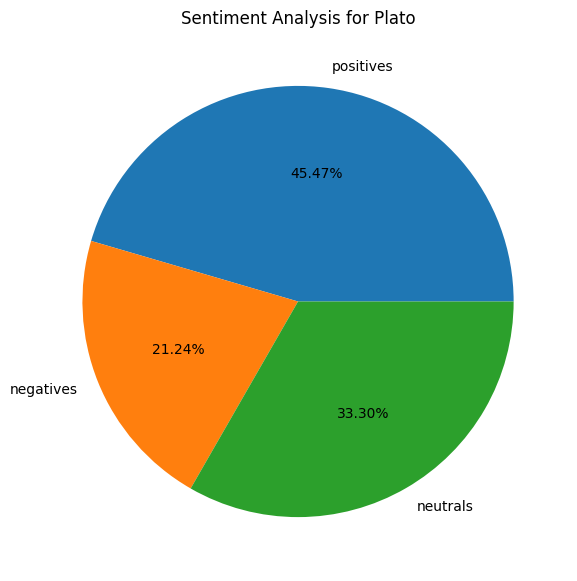

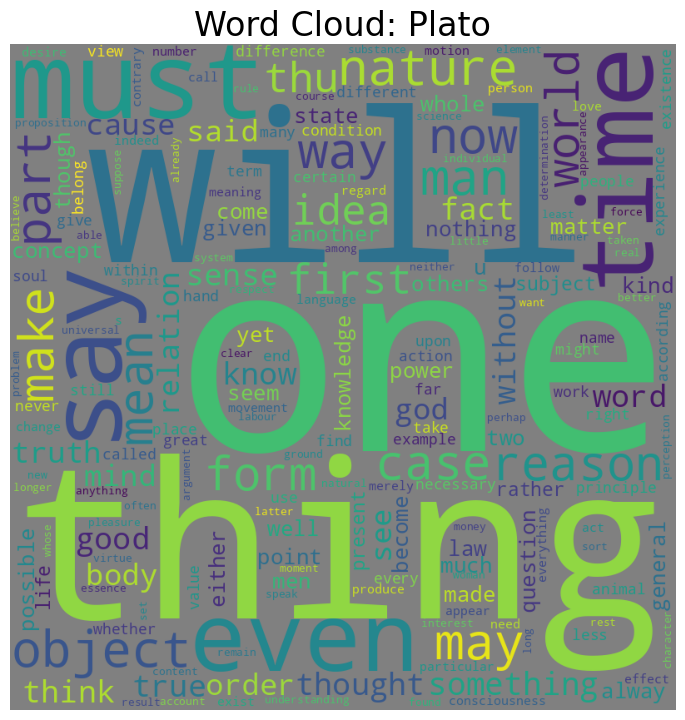

Time taken: 206.41230065900004


In [12]:
AnalyzerClass = DataAnalyzer(df)
AnalyzerClass.displayAnalysis('Plato')
# for author in list(df['author'].drop_duplicates()):
#     AnalyzerClass.displayAnalysis(df, author)